In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)
import random
import pandas as pd
import numpy as np

 # [HomeWork](#hw_1)

### Загрузим датасет

На занятии мы познакомимся с датасетом Симпсонов! Там собраны знакомые многим персонажи знаменитого мультфильма для решения задачи классификации.

Все данные теперь находятся в папке `data`.

Тестовые данные (`kaggle_simpson_testset/`) сегодня не пригодятся.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [2]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data\\simpsons_dataset\\simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}\*\*.jpg")
data_image_labels = [path.split('\\')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

In [26]:
def check_Image1(path):
    try:
        path in train_files_path
        return True
    except:
        return False

def check_Image2(path):
    try:
        path in val_files_path
        return True
    except:
        return False
    
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=check_Image1
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=check_Image2
)

In [27]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [28]:
print(len(train_dataset.targets))
y = np.bincount(np.array(train_dataset.targets))
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

20933


[(0, 913),
 (1, 42),
 (2, 623),
 (3, 106),
 (4, 1342),
 (5, 98),
 (6, 1193),
 (7, 986),
 (8, 47),
 (9, 469),
 (10, 8),
 (11, 457),
 (12, 27),
 (13, 27),
 (14, 121),
 (15, 2246),
 (16, 498),
 (17, 1206),
 (18, 310),
 (19, 3),
 (20, 1354),
 (21, 128),
 (22, 1291),
 (23, 71),
 (24, 246),
 (25, 1079),
 (26, 17),
 (27, 1452),
 (28, 1454),
 (29, 358),
 (30, 32),
 (31, 72),
 (32, 1194),
 (33, 65),
 (34, 45),
 (35, 89),
 (36, 103),
 (37, 877),
 (38, 40),
 (39, 55),
 (40, 8),
 (41, 181)]

Посмотрим на изображения из `val` и `train`

In [6]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

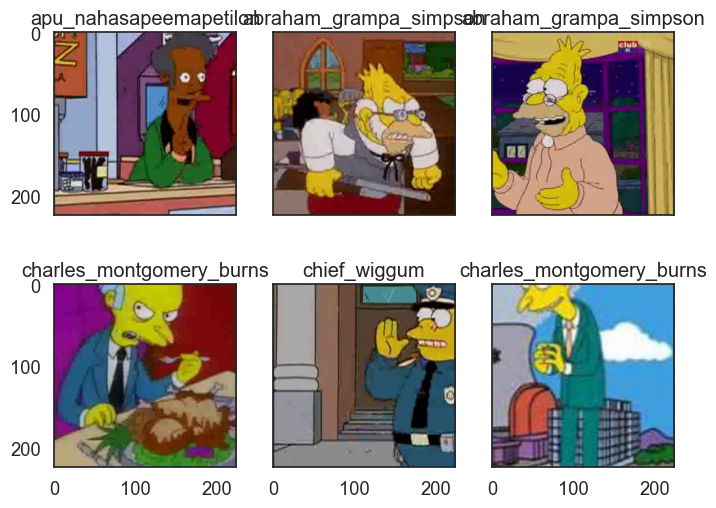

In [7]:
show_images(val_dataset)

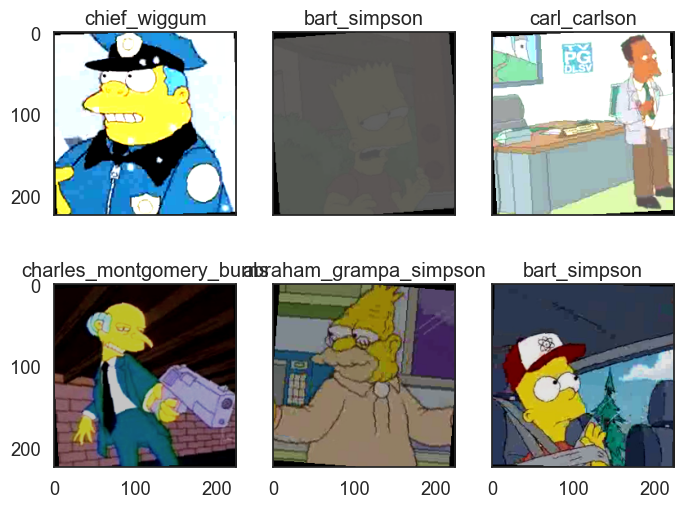

In [8]:
show_images(train_dataset)

Невооруженным взглядом видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [8]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [19]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.cpu().numpy())
            y_pred = logits.max(1)[1].cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [118]:
batch_size = 32

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [10]:
from torchvision.models import resnet18

Обучим `Resnet18` с нуля

Epoch 10 of 10 took 197.904s
  training loss (in-iteration): 	1.826983
  validation loss (in-iteration): 	1.602347
  training accuracy: 			50.28 %
  validation accuracy: 			56.28 %


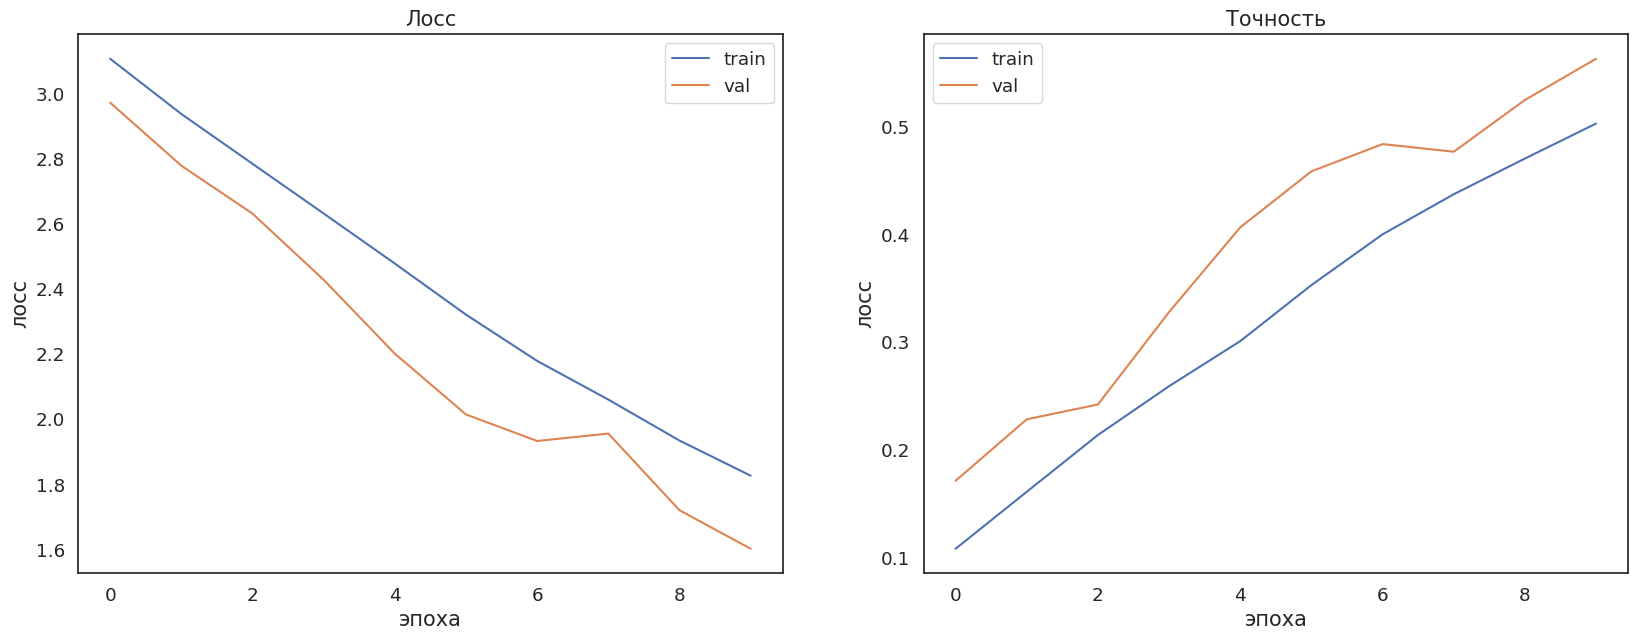

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Будем использовать сеть как `Feature Extractor`

Epoch 10 of 10 took 173.565s
  training loss (in-iteration): 	1.584347
  validation loss (in-iteration): 	1.384386
  training accuracy: 			59.69 %
  validation accuracy: 			65.42 %


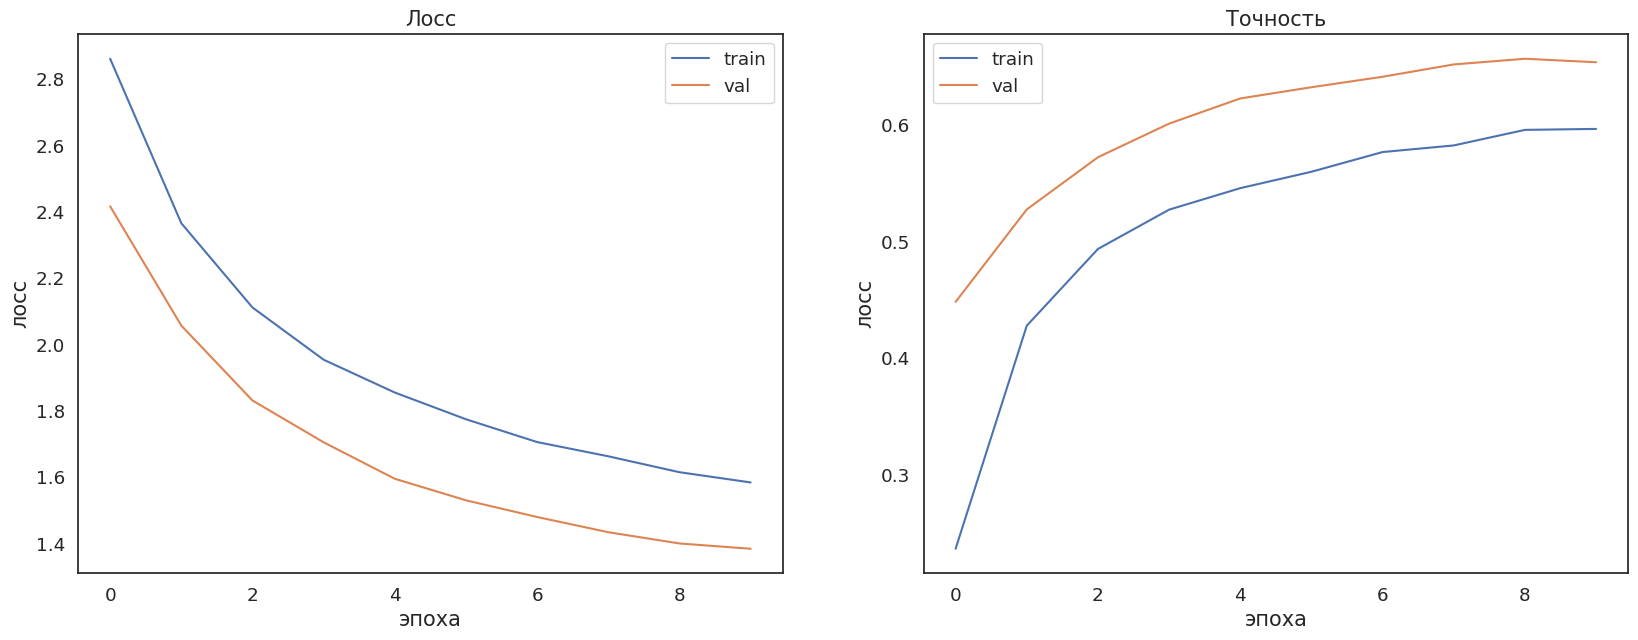

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Будем использовать как `FineTuning`

Epoch 10 of 10 took 191.909s
  training loss (in-iteration): 	0.095015
  validation loss (in-iteration): 	0.214800
  training accuracy: 			97.50 %
  validation accuracy: 			94.41 %


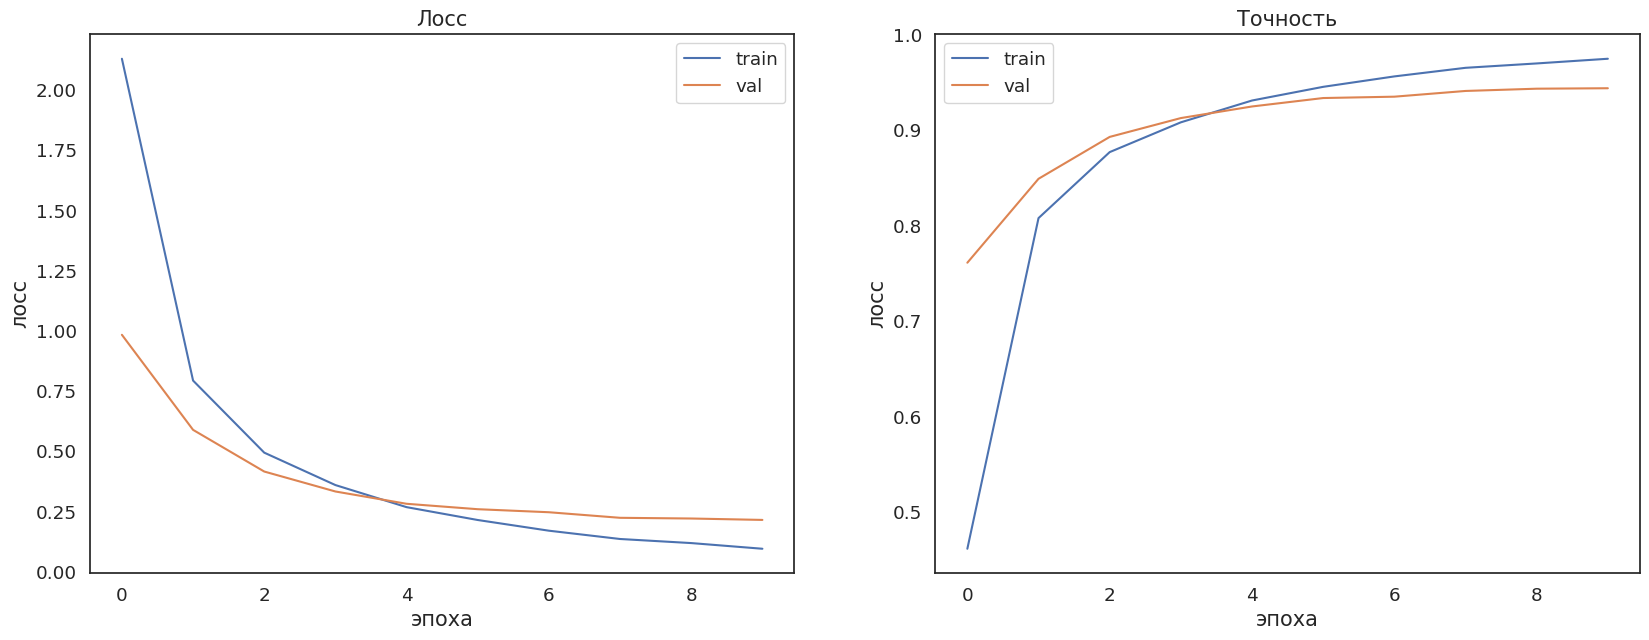

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Почему в данном случае обучение с нуля дало худший результат, а fine tuning -- наилучший?

**Документация по шедулерам**

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

# HW <a class="anchor" id="hw_1"></a>

In [6]:
from torchvision.models import resnet18, ResNet18_Weights, mobilenet
import copy

In [7]:
#класс тренировки и тестирования одной модели, сохраняет результаты по каждой эпохе в соответствующие массивы
class TTresults:
    
    def __init__(self,trainer,loss,scheduler=None,cuda=False,show_train=True,show_iter_n = 50):
        
        self.loss = loss
        self.trainer = trainer
        self.scheduler = scheduler
        self.cuda = cuda
        self.show_train = show_train
        self.show_iter_n = show_iter_n
        
        self.e_train_times=[]
        self.e_test_times=[]
        self.e_train_loss =[]
        self.e_train_acc =[]
        self.e_test_loss =[]
        self.e_test_acc =[]
    
    def train(self,net, train_iter, test_iter,num_epochs):
        if self.cuda:
            net.to(device)
        net.train()
        for epoch in range(num_epochs):
            
            train_l_sum, train_acc_sum, n, iters, start = 0.0, 0.0, 0, 0, time.time()
            for i, (X, y) in enumerate(train_iter):
                if self.cuda:
                    X, y = X.to(device), y.to(device)
                self.trainer.zero_grad()
                y_hat = net(X)
                l = self.loss(y_hat, y)
                l.backward()
                self.trainer.step()
                
                train_l_sum += l.item()
                train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
                n += y.shape[0]
                iters += 1
                #torch.cuda.empty_cache()
                
                if self.show_iter_n > 0 and i % self.show_iter_n==0:
                    print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / iters:.3f}")
                
            if self.scheduler:
                    self.scheduler.step()
                
            self.e_train_times.append(time.time() -  start)
            self.e_train_loss.append(train_l_sum / iters)
            self.e_train_acc.append(train_acc_sum / n)
                
            test_acc = self.evaluate_accuracy(test_iter, net)
            if self.show_train:
                self.show_epoch(epoch)
            
        net.to('cpu')
                
    def show_epoch(self,epoch):
        print("ep: {}, tt_time: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            epoch, 
            self.e_train_times[-1]+self.e_test_times[-1], 
            round(self.e_train_loss[-1],5), 
            round(self.e_train_acc[-1],5),
            round(self.e_test_loss[-1],5), 
            round(self.e_test_acc[-1],5)))
    
    def evaluate_accuracy(self,data_iter,net):
        l_sum, acc_sum, n, iters, start= 0, 0, 0, 0, time.time()
        
        net.eval()
        for X, y in data_iter:
            if self.cuda:
                X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = self.loss(y_hat, y)
            l_sum += l.item()
            acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            iters += 1
            #torch.cuda.empty_cache()
            
        self.e_test_times.append(time.time() -  start)
        self.e_test_loss.append(l_sum / iters)
        self.e_test_acc.append(acc_sum / n)

    def get_last_results(self):
        r = {}
        r['train_time'] =  self.e_train_times
        r['test_time']  =  self.e_test_times
        r['train_loss']  =  self.e_train_loss
        r['train_acc']  =  self.e_train_acc
        r['test_loss']  =  self.e_test_loss
        r['test_acc']  =  self.e_test_acc
        r = pd.DataFrame(r)
        r['ep'] = r.index
        return r
    
    
# запускает каждую модель из списка кортежей (имя,модель), берёт результаты последней эпохи, сохраняет их в df
# берём одинаковые loss и оптимизатор для всех моделей
class ComparisonTable:
    def __init__(self,models: list[tuple], 
                 loss_f, 
                 trainer_f, 
                 scheduler,
                 epoch_n, 
                 cuda=False,
                 show_epoch=True,
                 show_iter=0):
        
        if len(set([id(x[1]) for x in models])) != len(models):
            raise "Модели задублированы"
        self.models = models
        self.cuda = cuda
        self.loss_f = loss_f
        self.trainer_f = trainer_f
        self.scheduler = scheduler
        self.show_epoch = show_epoch
        self.show_iter = show_iter
        
        self.epoch_n = epoch_n
        self.result = pd.DataFrame()
        
    def get_comparison_table(self,train_iter,test_iter)->pd.DataFrame:
        result = pd.DataFrame()
        
        for name,model,transforms in self.models:
            print('-'*20)
            print(f'{name} model was started')
            
            if transforms:
                train_iter.dataset.transform = transforms
                test_iter.dataset.transform = transforms
            
            r = self.train_one(model,train_iter,test_iter)
            r['model_name'] = name
            if result.shape[0]==0:
                result = r.copy()
            else:
                result = result.append(r,ignore_index=True)
                
       
        return result
    
    def train_one(self,model,train_iter,test_iter):
        
        loss = self.loss_f #copy.deepcopy(
        trainer =  self.trainer_f
        scheduler = self.scheduler
        
        num_epochs = self.epoch_n
        
        tt = TTresults(trainer,loss,scheduler,cuda=self.cuda,show_train=self.show_epoch,show_iter_n=self.show_iter)
        tt.train(model, train_iter, test_iter, num_epochs)
        
        return tt.get_last_results()

In [35]:
def show_plot(df,name):
    
    tdf1 = df[df['model_name']==name][[
    'ep','train_loss','test_loss']].set_index('ep').unstack(1).reset_index().rename(columns={'level_0':'loss',0:'val'})
    tdf2 = df[df['model_name']==name][[
    'ep','train_acc','test_acc']].set_index('ep').unstack(1).reset_index().rename(columns={'level_0':'acc',0:'val'})
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    _ =sns.lineplot(ax=axes[0],data=tdf1, x='ep', y='val', hue='loss')
    _ =sns.lineplot(ax=axes[1],data=tdf2, x='ep', y='val', hue='acc')

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [29]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### Rate Scheduling

In [11]:
#возьмём натренированную модель c feature extractor и прогоним с разными rate scheduling
def create_resnet18(model_name,rate_scheduling,base_lr=0.01,transforms=None):
    
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Linear(512, 42)
    model = model.to(device)
    params_to_update = []
    
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            
    criterion = nn.CrossEntropyLoss()
   
    optimizer = torch.optim.SGD(params_to_update, lr=base_lr)
    
    if rate_scheduling =='StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    elif rate_scheduling =='CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, 
                                                      max_lr=0.1,step_size_up=5,mode="triangular")
        
    else:
        
        scheduler = None
    
    return [(model_name,model,transforms)],criterion,optimizer,scheduler


num_epochs = 10

In [55]:
#без rate scheduling
name = 'resnet18_clean'
rs =  None
model = create_resnet18(name,rs,base_lr=0.01,transforms=None)
ct  = ComparisonTable(*model, num_epochs,cuda=True)
c_table = ct.get_comparison_table(train_batch_gen, val_batch_gen)

--------------------
resnet18_clean model was started
Step 0. time since epoch: 0.706. Train acc: 0.016. Train Loss: 3.924
Step 50. time since epoch: 19.270. Train acc: 0.105. Train Loss: 3.227
Step 100. time since epoch: 38.115. Train acc: 0.143. Train Loss: 3.083
Step 150. time since epoch: 56.749. Train acc: 0.180. Train Loss: 2.991
Step 200. time since epoch: 75.809. Train acc: 0.209. Train Loss: 2.918
Step 250. time since epoch: 94.795. Train acc: 0.238. Train Loss: 2.846
Step 300. time since epoch: 113.469. Train acc: 0.264. Train Loss: 2.785
ep: 0, tt_time: 214.332, train_loss: 2.75373, train_acc: 0.27426, test_loss: 2.28003, test_acc: 0.41318
Step 0. time since epoch: 0.369. Train acc: 0.359. Train Loss: 2.387
Step 50. time since epoch: 19.138. Train acc: 0.418. Train Loss: 2.323
Step 100. time since epoch: 38.213. Train acc: 0.437. Train Loss: 2.296
Step 150. time since epoch: 58.522. Train acc: 0.443. Train Loss: 2.275
Step 200. time since epoch: 77.307. Train acc: 0.453. Tra

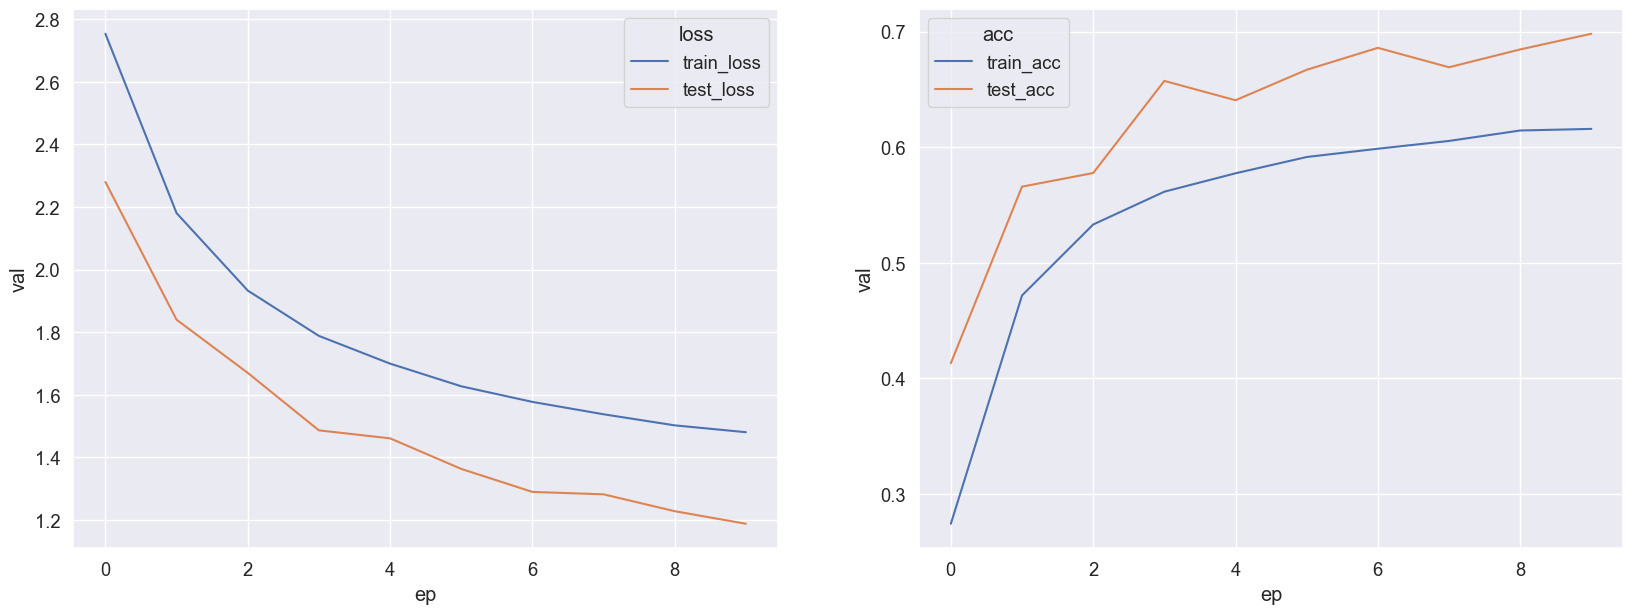

In [65]:
show_plot(c_table,name)

In [66]:
c_table.to_csv(f'{name}_data.csv',index=True)

In [43]:
#StepLR
name = 'resnet18_stepLR'
rs = 'StepLR'
model = create_resnet18(name,rs,base_lr=0.1,transforms=None)
ct  = ComparisonTable(*model, num_epochs,cuda=True)
c_table2 = ct.get_comparison_table(train_batch_gen, val_batch_gen)

--------------------
resnet18_stepLR model was started
Step 0. time since epoch: 0.573. Train acc: 0.000. Train Loss: 4.025
Step 50. time since epoch: 19.252. Train acc: 0.132. Train Loss: 5.544
Step 100. time since epoch: 37.853. Train acc: 0.190. Train Loss: 4.875
Step 150. time since epoch: 56.820. Train acc: 0.246. Train Loss: 4.187
Step 200. time since epoch: 75.738. Train acc: 0.289. Train Loss: 3.755
Step 250. time since epoch: 95.123. Train acc: 0.318. Train Loss: 3.509
Step 300. time since epoch: 114.433. Train acc: 0.343. Train Loss: 3.274
ep: 0, tt_time: 216.826, train_loss: 3.18211, train_acc: 0.35289, test_loss: 5.7594, test_acc: 0.19553
Step 0. time since epoch: 0.364. Train acc: 0.172. Train Loss: 5.464
Step 50. time since epoch: 19.408. Train acc: 0.502. Train Loss: 2.015
Step 100. time since epoch: 39.065. Train acc: 0.517. Train Loss: 1.954
Step 150. time since epoch: 58.391. Train acc: 0.525. Train Loss: 1.929
Step 200. time since epoch: 77.324. Train acc: 0.538. Tra

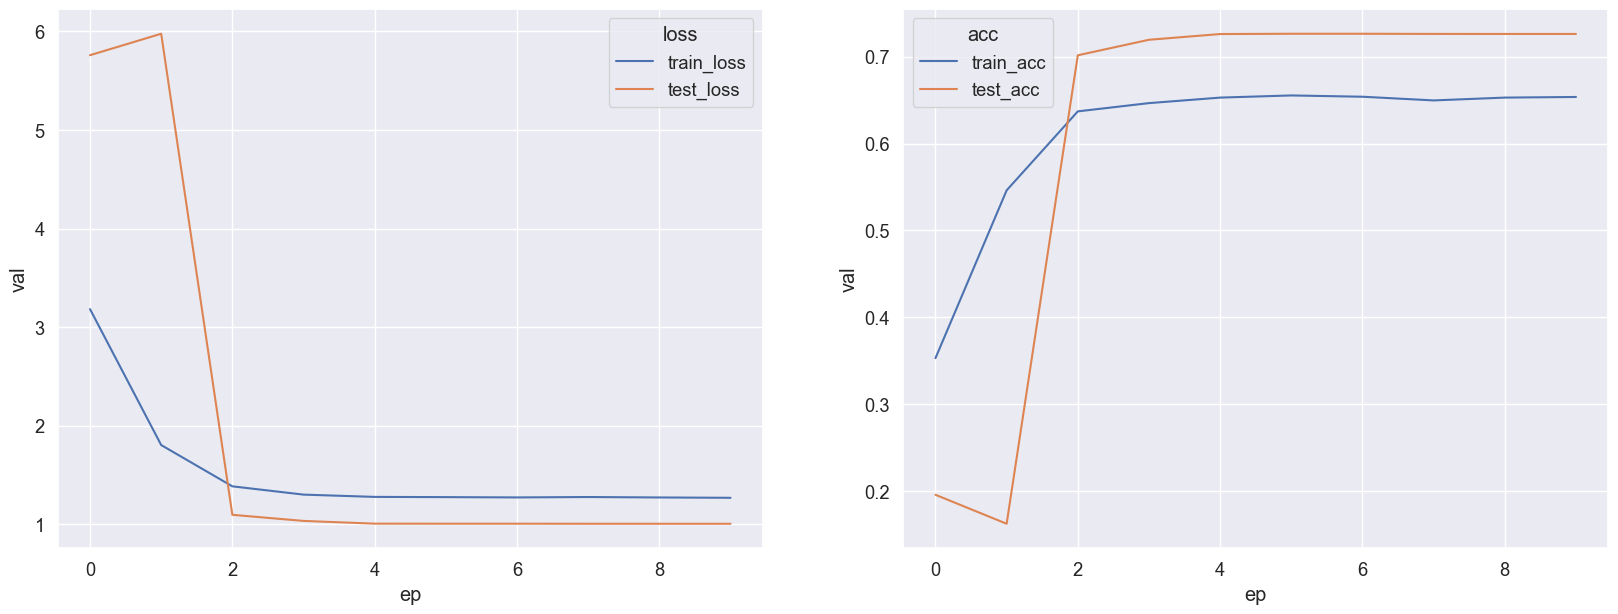

In [44]:
show_plot(c_table2,name)

In [45]:
c_table2.to_csv(f'{name}_data.csv',index=True)

In [46]:
#StepLR
name = 'resnet18_CyclicLR'
rs = 'CyclicLR'
model = create_resnet18(name,rs,base_lr=0.01,transforms=None)
ct  = ComparisonTable(*model, num_epochs,cuda=True)
c_table3 = ct.get_comparison_table(train_batch_gen, val_batch_gen)

C:\Users\RK\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\RK\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------
resnet18_CyclicLR model was started
Step 0. time since epoch: 0.387. Train acc: 0.000. Train Loss: 4.009
Step 50. time since epoch: 19.605. Train acc: 0.103. Train Loss: 3.292
Step 100. time since epoch: 38.815. Train acc: 0.136. Train Loss: 3.143
Step 150. time since epoch: 57.747. Train acc: 0.178. Train Loss: 3.035
Step 200. time since epoch: 77.317. Train acc: 0.209. Train Loss: 2.955
Step 250. time since epoch: 97.587. Train acc: 0.238. Train Loss: 2.881
Step 300. time since epoch: 116.927. Train acc: 0.263. Train Loss: 2.817
ep: 0, tt_time: 222.014, train_loss: 2.78309, train_acc: 0.27655, test_loss: 2.22566, test_acc: 0.51307
Step 0. time since epoch: 0.395. Train acc: 0.391. Train Loss: 2.489
Step 50. time since epoch: 20.567. Train acc: 0.387. Train Loss: 2.369
Step 100. time since epoch: 40.936. Train acc: 0.443. Train Loss: 2.137
Step 150. time since epoch: 61.409. Train acc: 0.478. Train Loss: 2.001
Step 200. time since epoch: 81.030. Train acc: 0.493. 

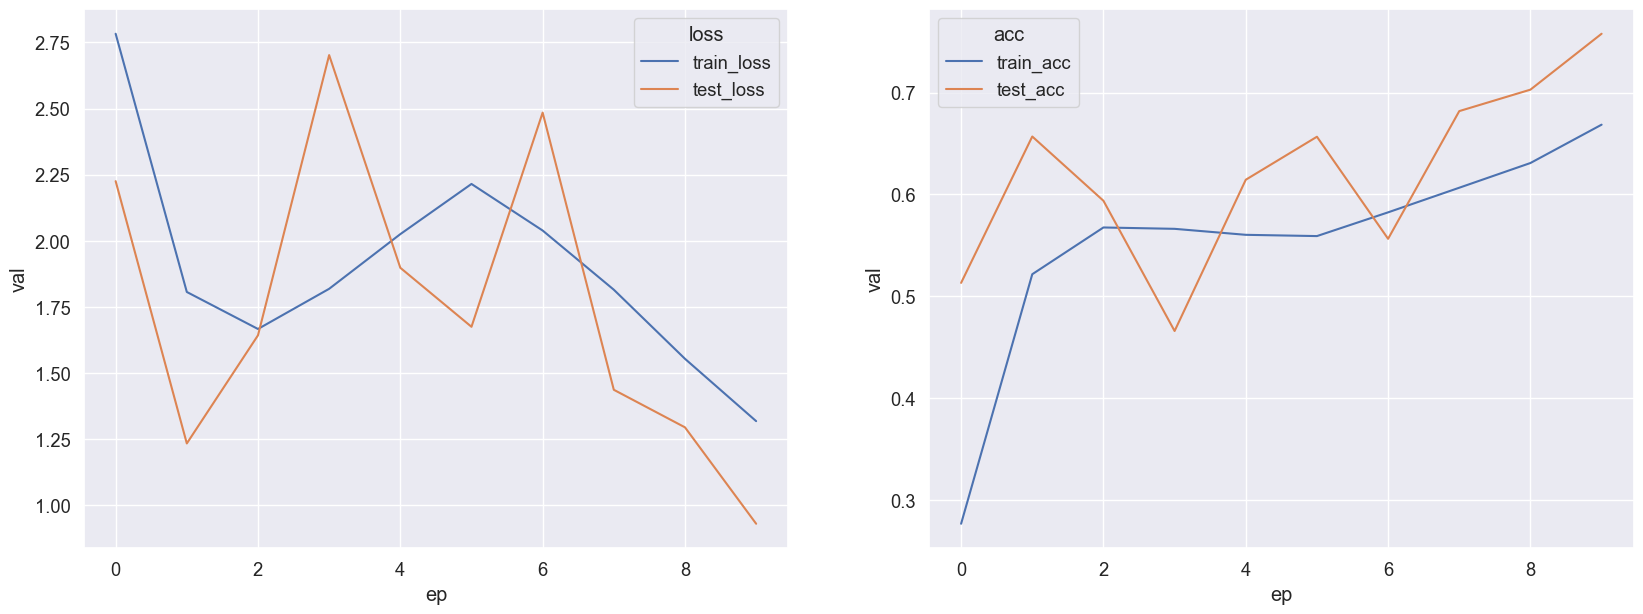

In [47]:
show_plot(c_table3,name)

In [48]:
c_table3.to_csv(f'{name}_data.csv',index=True)

## Аугментация

In [11]:
### input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation((0.4,0.9),expand=True,center=(50,50)),
    transforms.RandomResizedCrop(input_size, scale=(0.1, 0.3)),
    transforms.CenterCrop(input_size),
    transforms.RandomGrayscale(p=0.99),
    
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=check_Image1
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=check_Image2
)

batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [79]:
#предобученная модель
name = 'resnet18_clean'
rs =  None
model = create_resnet18(name,rs,base_lr=0.01,transforms=None)
ct  = ComparisonTable(*model, num_epochs,cuda=True)
c_table = ct.get_comparison_table(train_batch_gen, val_batch_gen)

--------------------
resnet18_clean model was started
Step 0. time since epoch: 0.614. Train acc: 0.078. Train Loss: 3.965
Step 50. time since epoch: 18.044. Train acc: 0.098. Train Loss: 3.250
Step 100. time since epoch: 35.807. Train acc: 0.113. Train Loss: 3.157
Step 150. time since epoch: 53.934. Train acc: 0.126. Train Loss: 3.106
Step 200. time since epoch: 71.837. Train acc: 0.141. Train Loss: 3.059
Step 250. time since epoch: 89.918. Train acc: 0.153. Train Loss: 3.018
Step 300. time since epoch: 107.633. Train acc: 0.165. Train Loss: 2.990
ep: 0, tt_time: 212.052, train_loss: 2.97618, train_acc: 0.16882, test_loss: 3.23439, test_acc: 0.10357
Step 0. time since epoch: 0.370. Train acc: 0.250. Train Loss: 2.641
Step 50. time since epoch: 17.977. Train acc: 0.246. Train Loss: 2.766
Step 100. time since epoch: 36.033. Train acc: 0.256. Train Loss: 2.745
Step 150. time since epoch: 54.061. Train acc: 0.262. Train Loss: 2.726
Step 200. time since epoch: 72.110. Train acc: 0.267. Tra

In [ ]:
#Очень плохое качество на тесте, что и требовалось

## Feature Extractor и FineTuning

In [34]:
mobil = mobilenet.mobilenet_v3_small(weights=mobilenet.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

In [35]:
mobil

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [16]:
#summary(mobil, input_size=(3, 224, 224), device='cpu')

In [17]:
#Обучение с нуля
model_clean = mobilenet.mobilenet_v3_small(weights=None)
model_clean.classifier[3] = nn.Linear(1024, 42)

models_list = [('mobileNet_clean',model_clean,None)]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_clean.parameters(), lr=0.01)
scheduler = None
num_epochs = 10
ct  = ComparisonTable(models_list, criterion, optimizer,scheduler,num_epochs,cuda=True,show_epoch=True,show_iter=0)
c_table = ct.get_comparison_table(train_batch_gen, val_batch_gen)


--------------------
mobileNet_clean model was started
ep: 0, tt_time: 275.239, train_loss: 3.63156, train_acc: 0.104, test_loss: 3.61948, test_acc: 0.10729
ep: 1, tt_time: 220.473, train_loss: 3.48734, train_acc: 0.10729, test_loss: 3.26634, test_acc: 0.10729
ep: 2, tt_time: 215.183, train_loss: 3.14283, train_acc: 0.10729, test_loss: 3.12236, test_acc: 0.10729
ep: 3, tt_time: 211.667, train_loss: 3.11318, train_acc: 0.10729, test_loss: 3.12298, test_acc: 0.10729
ep: 4, tt_time: 214.415, train_loss: 3.11269, train_acc: 0.10729, test_loss: 3.11869, test_acc: 0.10729
ep: 5, tt_time: 213.939, train_loss: 3.10939, train_acc: 0.10729, test_loss: 3.115, test_acc: 0.10729
ep: 6, tt_time: 212.087, train_loss: 3.10946, train_acc: 0.10729, test_loss: 3.11512, test_acc: 0.10729
ep: 7, tt_time: 210.754, train_loss: 3.1118, train_acc: 0.10729, test_loss: 3.11699, test_acc: 0.10729
ep: 8, tt_time: 207.433, train_loss: 3.10841, train_acc: 0.10729, test_loss: 3.12143, test_acc: 0.10729
ep: 9, tt_time

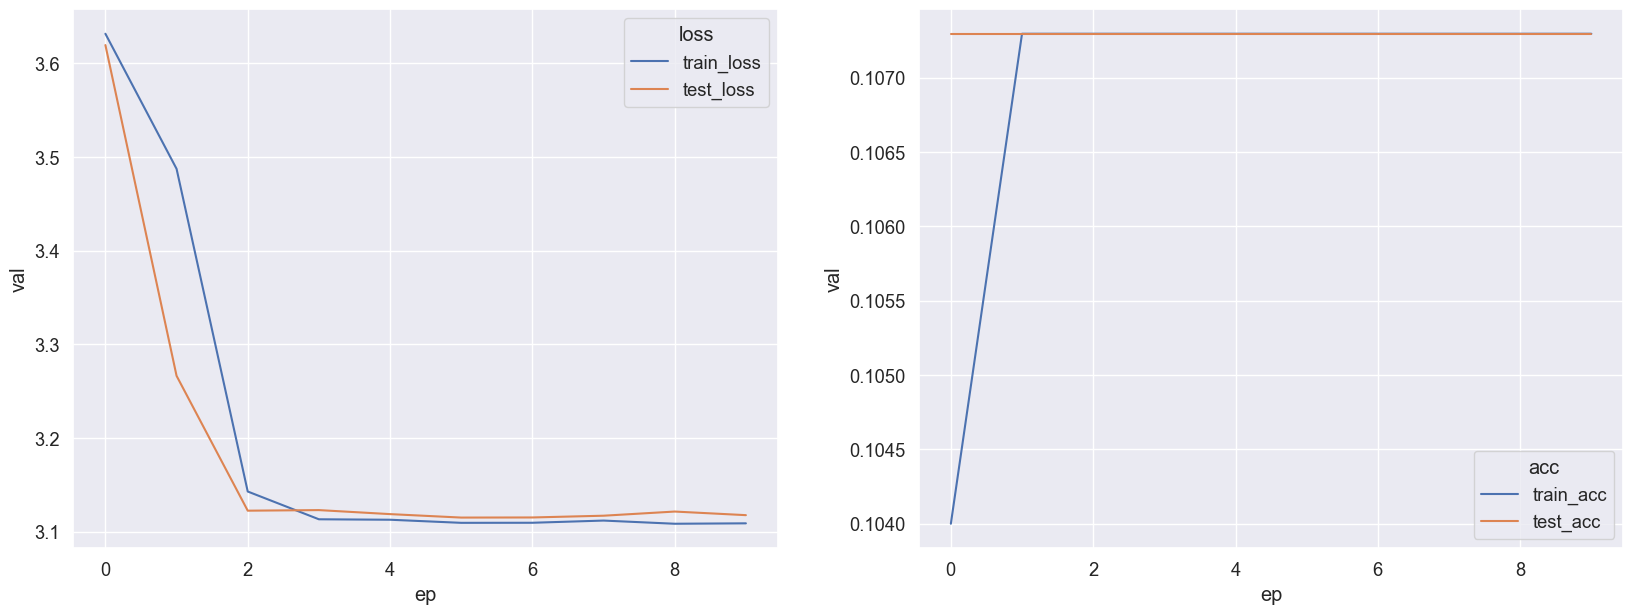

In [18]:
show_plot(c_table,'mobileNet_clean')

In [20]:
#FeatureWxtractor
model_fExt = mobilenet.mobilenet_v3_small(weights=mobilenet.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
for param in model_fExt.parameters():
    param.requires_grad = False

model_fExt.classifier[3] = nn.Linear(1024, 42)

params_to_update = []
for name, param in model_fExt.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
       
    
models_list = [('mobileNet_fExt',model_fExt,None)]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.01)
scheduler = None
num_epochs = 10
ct  = ComparisonTable(models_list, criterion, optimizer,scheduler,num_epochs,cuda=True,show_epoch=True,show_iter=0)
c_table = ct.get_comparison_table(train_batch_gen, val_batch_gen)   

--------------------
mobileNet_fExt model was started
ep: 0, tt_time: 245.402, train_loss: 3.17901, train_acc: 0.28228, test_loss: 2.55945, test_acc: 0.51674
ep: 1, tt_time: 219.851, train_loss: 2.43257, train_acc: 0.48431, test_loss: 1.96378, test_acc: 0.59146
ep: 2, tt_time: 217.974, train_loss: 2.06486, train_acc: 0.53805, test_loss: 1.69784, test_acc: 0.63398
ep: 3, tt_time: 208.330, train_loss: 1.87539, train_acc: 0.5671, test_loss: 1.54123, test_acc: 0.65987
ep: 4, tt_time: 210.708, train_loss: 1.74411, train_acc: 0.59337, test_loss: 1.43563, test_acc: 0.67687
ep: 5, tt_time: 209.916, train_loss: 1.66226, train_acc: 0.60073, test_loss: 1.35789, test_acc: 0.68872
ep: 6, tt_time: 209.190, train_loss: 1.59594, train_acc: 0.61233, test_loss: 1.29776, test_acc: 0.69622
ep: 7, tt_time: 210.150, train_loss: 1.54865, train_acc: 0.62308, test_loss: 1.2461, test_acc: 0.70477
ep: 8, tt_time: 209.745, train_loss: 1.50018, train_acc: 0.63159, test_loss: 1.20298, test_acc: 0.71328
ep: 9, tt_ti

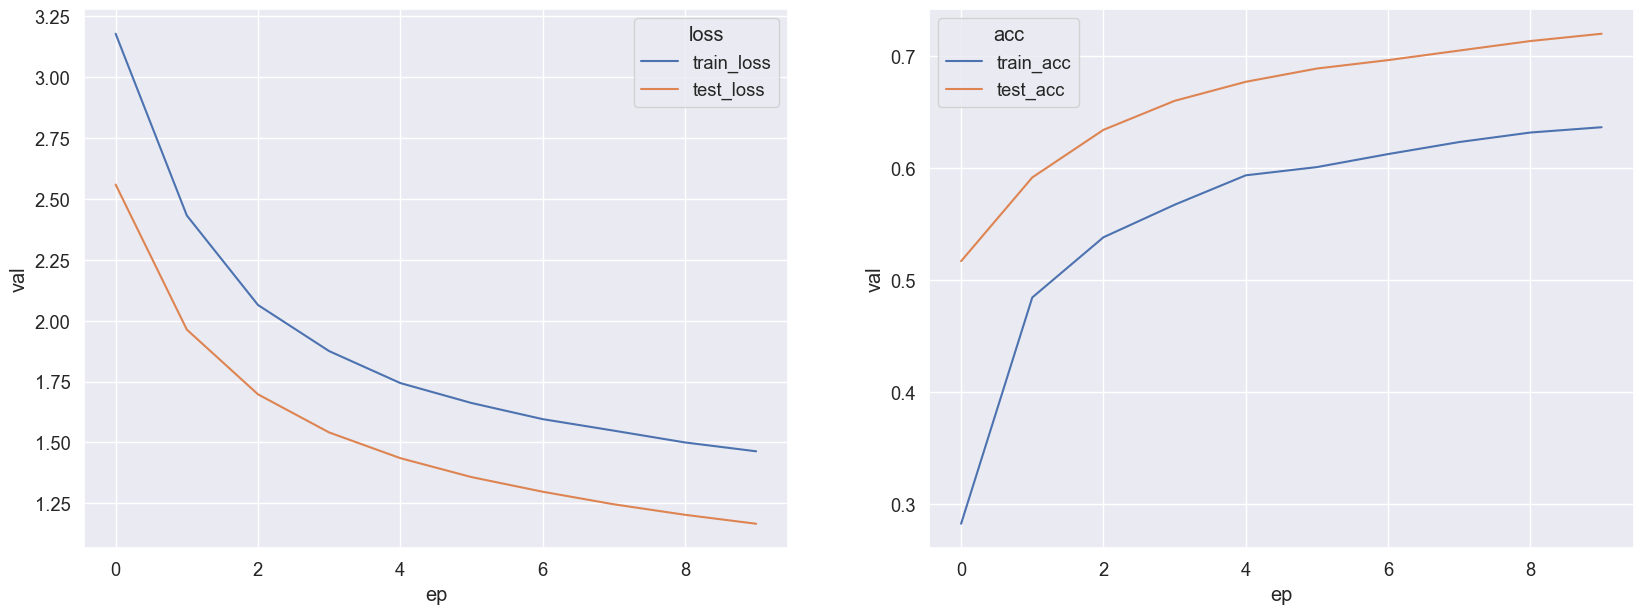

In [21]:
show_plot(c_table,'mobileNet_fExt')

In [31]:
#FineTuning

fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('mobilnet', 
                             mobilenet.mobilenet_v3_small(weights=mobilenet.MobileNet_V3_Small_Weights.IMAGENET1K_V1))
    
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('do1', nn.Dropout(0.5))
fine_tuning_model.add_module('fc_3', nn.Linear(512, 42))

        
models_list = [('mobileNet_fine_tuning',fine_tuning_model,None)]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = None
num_epochs = 10
ct  = ComparisonTable(models_list, criterion, optimizer,scheduler,num_epochs,cuda=True,show_epoch=True,show_iter=0)
c_table = ct.get_comparison_table(train_batch_gen, val_batch_gen)   

--------------------
mobileNet_fine_tuning model was started
ep: 0, tt_time: 210.714, train_loss: 2.422, train_acc: 0.35518, test_loss: 1.57021, test_acc: 0.59681
ep: 1, tt_time: 208.362, train_loss: 1.21158, train_acc: 0.68958, test_loss: 0.86314, test_acc: 0.75121
ep: 2, tt_time: 211.601, train_loss: 0.64263, train_acc: 0.83122, test_loss: 0.74786, test_acc: 0.78283
ep: 3, tt_time: 211.504, train_loss: 0.4967, train_acc: 0.86748, test_loss: 1.11992, test_acc: 0.69933
ep: 4, tt_time: 212.407, train_loss: 0.4093, train_acc: 0.89041, test_loss: 0.82785, test_acc: 0.7632
ep: 5, tt_time: 208.753, train_loss: 0.3395, train_acc: 0.91043, test_loss: 0.22825, test_acc: 0.94105
ep: 6, tt_time: 206.895, train_loss: 0.29848, train_acc: 0.9186, test_loss: 0.25656, test_acc: 0.9282
ep: 7, tt_time: 207.309, train_loss: 0.25825, train_acc: 0.93216, test_loss: 0.16515, test_acc: 0.95825
ep: 8, tt_time: 208.258, train_loss: 0.23989, train_acc: 0.93508, test_loss: 0.14924, test_acc: 0.96102
ep: 9, tt_t

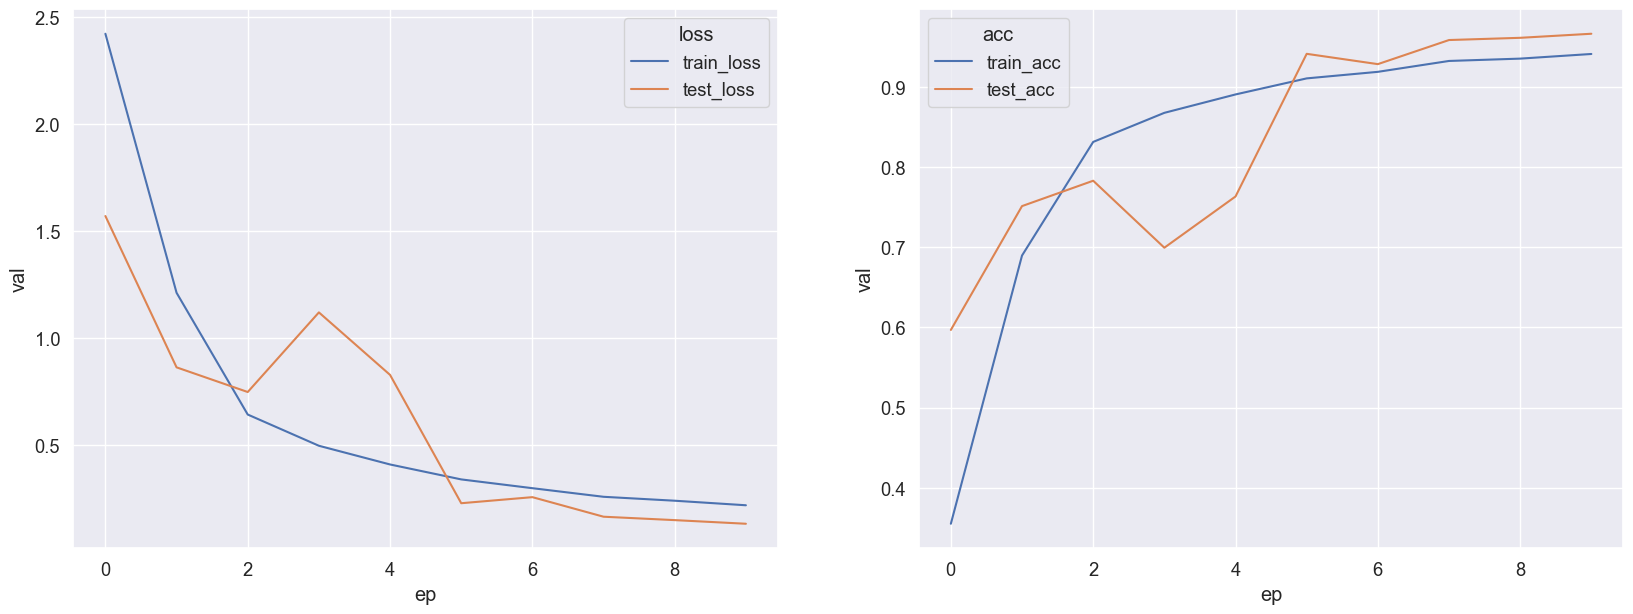

In [36]:
show_plot(c_table,'mobileNet_fine_tuning')

## Выводы

In [ ]:
Rate Scheduling: применение методик изменения скорости обучения даёт улучшение качества, 
    если учесть следующие моменты:
        1. Диапазон приемлемых значений lr, чтобы шедулер в течении обучении не слишком сильно его завышал/занижал
        2. Как часто применять изменения lr (можно по эпохам а можно, например, по 100-ой итерации)
        3. Соответствие количества эпох цикличности шедулера, если таковая имеется.

Аугментация: хороший подход, позволяющий снизить переобучение, повысить качество, однако навредить тоже возможно, 
    применив неверные параметры - нужно представлять, что делают с картинкой трансформации.

Feature Extractor и FineTuning: получены результаты, похожие на результаты представленные на уроке, 
    даже чуть более хорошим качестовом, с моделью mobilenet_v3_small - лучший результат показала модель 
    с предзагруженными весами и дополнительными слоями классификатора.
    Полагаю, что такой результат обусловлен тем, что обученная модель уже умеет находить 
    на картинках определённые паттерны. Фундамент решения схожих задач уже имеется и дообучится гораздо быстрее чем обучаться с нуля.
    Ну и дообучение с применением добавленного классификатора в отличие от варианта feature extractor дало лучший результат,
    так как добавленные слои обучаются решать именно нашу конкретную задачу.